In [3]:
# ==============================
# 1. IMPORT LIBRARIES
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [6]:
# ==============================
# 2. LOAD DATA
# ==============================
df = pd.read_csv(r"S:\SUNNY PC\Elevate labs - 4 Months\Datasets\creditcard.csv")

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nClass Distribution:\n", df["IsFraud"].value_counts())

Shape: (100000, 7)

Columns: ['TransactionID', 'TransactionDate', 'Amount', 'MerchantID', 'TransactionType', 'Location', 'IsFraud']

Class Distribution:
 IsFraud
0    99000
1     1000
Name: count, dtype: int64


In [7]:
# ==============================
# 3. FEATURE ENGINEERING
# ==============================

# Convert date column
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])

# Extract time features
df["Hour"] = df["TransactionDate"].dt.hour
df["Day"] = df["TransactionDate"].dt.day
df["Month"] = df["TransactionDate"].dt.month
df["Weekday"] = df["TransactionDate"].dt.weekday

# Drop original date
df.drop("TransactionDate", axis=1, inplace=True)

# Drop identifier
df.drop("TransactionID", axis=1, inplace=True)

In [8]:
# ==============================
# 4. ENCODE CATEGORICAL VARIABLES
# ==============================
cat_cols = ["TransactionType", "Location"]

le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

In [9]:
# ==============================
# 5. FEATURE / TARGET SPLIT
# ==============================
X = df.drop("IsFraud", axis=1)
y = df["IsFraud"]

In [10]:

# ==============================
# 6. TRAIN TEST SPLIT (STRATIFIED)
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [11]:
# ==============================
# 7. HANDLE IMBALANCE (SMOTE)
# ==============================
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("After SMOTE:", y_train_sm.value_counts())

After SMOTE: IsFraud
0    79200
1    79200
Name: count, dtype: int64


In [12]:
# ==============================
# 8. BASELINE MODEL – LOGISTIC REGRESSION
# ==============================
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train_sm)

log_pred = log_model.predict(X_test_scaled)

In [13]:
print("\n===== Logistic Regression =====")
print(confusion_matrix(y_test, log_pred))
print(classification_report(y_test, log_pred))
print("ROC-AUC:", roc_auc_score(y_test, log_model.predict_proba(X_test_scaled)[:,1]))


===== Logistic Regression =====
[[11644  8156]
 [  101    99]]
              precision    recall  f1-score   support

           0       0.99      0.59      0.74     19800
           1       0.01      0.49      0.02       200

    accuracy                           0.59     20000
   macro avg       0.50      0.54      0.38     20000
weighted avg       0.98      0.59      0.73     20000

ROC-AUC: 0.5433833333333333


In [14]:
# ==============================
# 9. RANDOM FOREST
# ==============================
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_sm, y_train_sm)

rf_pred = rf_model.predict(X_test)

print("\n===== Random Forest =====")
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]))


===== Random Forest =====
[[19261   539]
 [  193     7]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     19800
           1       0.01      0.04      0.02       200

    accuracy                           0.96     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.98      0.96      0.97     20000

ROC-AUC: 0.540385606060606


In [15]:
# ==============================
# 10. XGBOOST (Advanced Model)
# ==============================
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=10,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_model.fit(X_train_sm, y_train_sm)

xgb_pred = xgb_model.predict(X_test)

print("\n===== XGBoost =====")
print(confusion_matrix(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))
print("ROC-AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]))



===== XGBoost =====
[[10272  9528]
 [   98   102]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68     19800
           1       0.01      0.51      0.02       200

    accuracy                           0.52     20000
   macro avg       0.50      0.51      0.35     20000
weighted avg       0.98      0.52      0.67     20000

ROC-AUC: 0.52667398989899


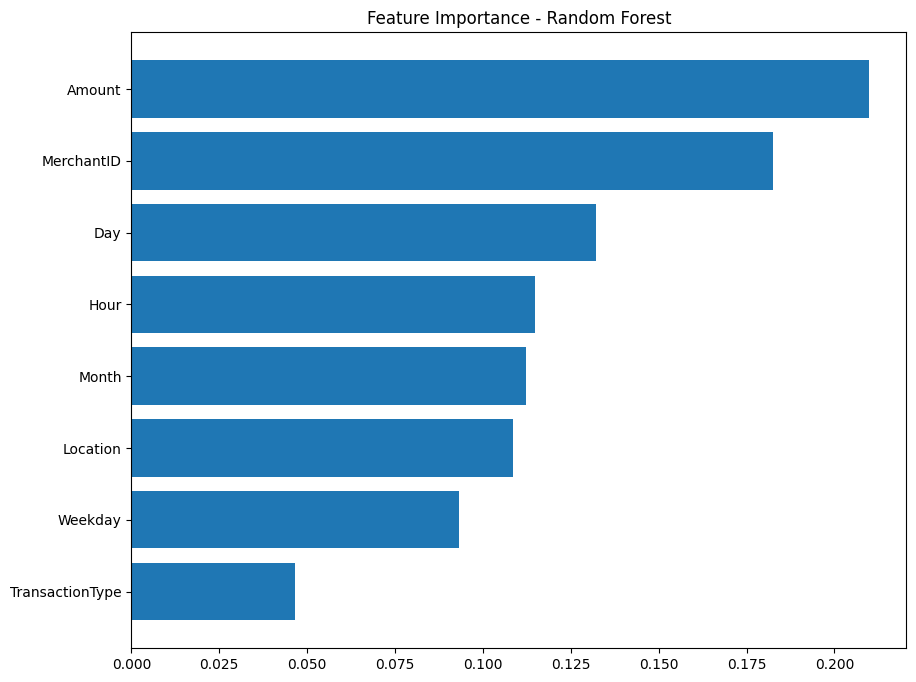

In [16]:
# ==============================
# 11. FEATURE IMPORTANCE (Random Forest)
# ==============================
importances = rf_model.feature_importances_
features = X.columns

feat_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,8))
plt.barh(feat_df["Feature"], feat_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance - Random Forest")
plt.show()

In [17]:
# ==============================
# 12. SAVE BEST MODEL
# ==============================
joblib.dump(rf_model, "fraud_random_forest.pkl")
joblib.dump(xgb_model, "fraud_xgboost.pkl")
joblib.dump(scaler, "scaler.pkl")

print("\nModels Saved Successfully.")


Models Saved Successfully.
